In [6]:
!pip install pyspark
!pip install findspark

In [7]:
import pyspark
import findspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, count, col

In [8]:
spark = SparkSession.builder.appName("FraudDetection").getOrCreate()

df = spark.read.csv("/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv", header=True, inferSchema=True)

NameError: name 'plt' is not defined

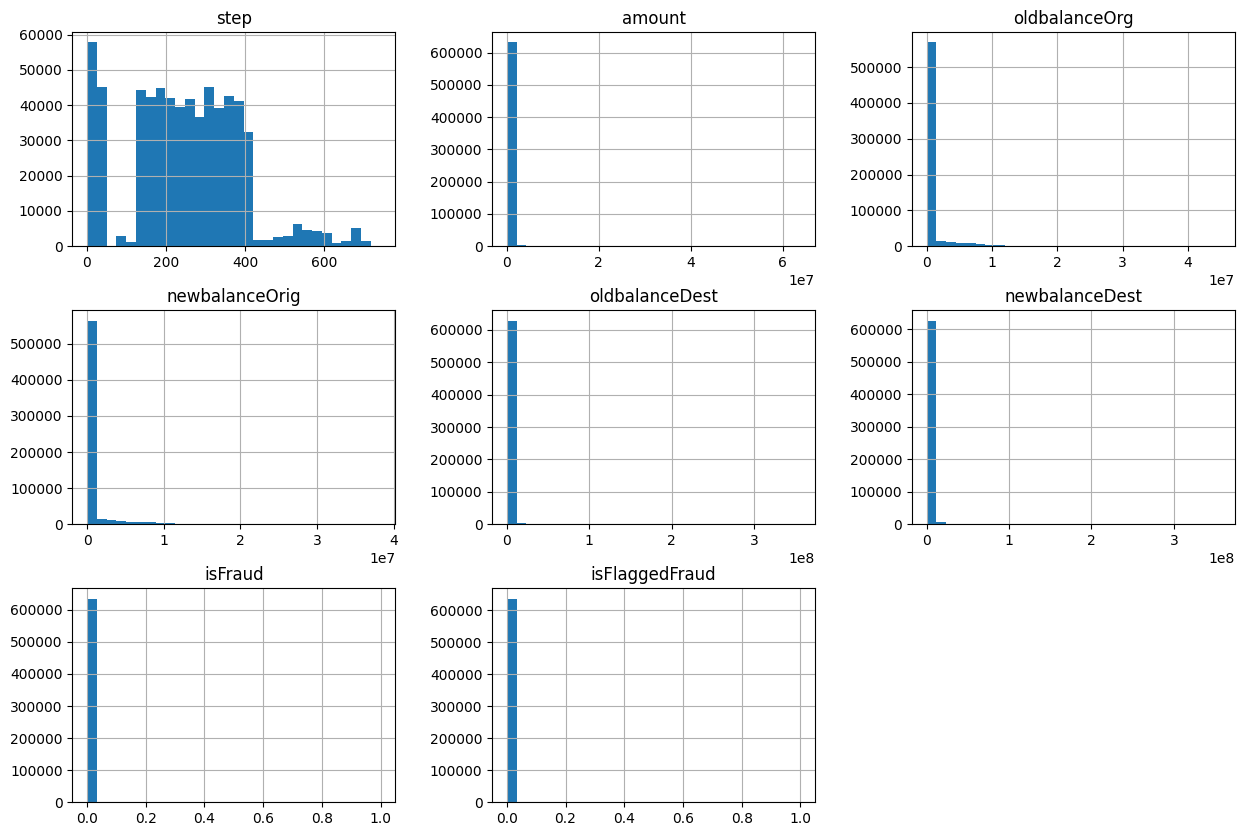

In [9]:
import pandas

data_sample = df.sample(fraction=0.1, seed=1234)
data_pandas_sample = data_sample.toPandas()

data_pandas_sample.hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()

In [10]:
print(df.columns)

['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']


In [12]:
df.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|      

## Data Preprocessing

In [13]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler

# Removing irrelevant columns
df_preprocessed = df.drop('nameOrig', 'nameDest')

# Convert categorical 'type' column
indexer = StringIndexer(inputCol="type", outputCol="typeIndex")
df_preprocessed = indexer.fit(df_preprocessed).transform(df_preprocessed)

# Prepare features for the model
assembler = VectorAssembler(inputCols=["step", "typeIndex", "amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"], outputCol="features")
df_preprocessed = assembler.transform(df_preprocessed)

df_preprocessed.select("features", "isFraud").show()

+--------------------+-------+
|            features|isFraud|
+--------------------+-------+
|[1.0,1.0,9839.64,...|      0|
|[1.0,1.0,1864.28,...|      0|
|[1.0,3.0,181.0,18...|      1|
|[1.0,0.0,181.0,18...|      1|
|[1.0,1.0,11668.14...|      0|
|[1.0,1.0,7817.71,...|      0|
|[1.0,1.0,7107.77,...|      0|
|[1.0,1.0,7861.64,...|      0|
|[1.0,1.0,4024.36,...|      0|
|[1.0,4.0,5337.77,...|      0|
|[1.0,4.0,9644.94,...|      0|
|[1.0,1.0,3099.97,...|      0|
|[1.0,1.0,2560.74,...|      0|
|[1.0,1.0,11633.76...|      0|
|[1.0,1.0,4098.78,...|      0|
|[1.0,0.0,229133.9...|      0|
|[1.0,1.0,1563.82,...|      0|
|[1.0,1.0,1157.86,...|      0|
|[1.0,1.0,671.64,1...|      0|
|[1.0,3.0,215310.3...|      0|
+--------------------+-------+
only showing top 20 rows



In [14]:
# Split data into training and testing sets (80% training, 20% testing)
train_df, test_df = df_preprocessed.randomSplit([0.8, 0.2], seed=42)

# Show the size of the datasets
print(f"Training Set Count: {train_df.count()}")
print(f"Test Set Count: {test_df.count()}")


Training Set Count: 5089858


Test Set Count: 1272762


In [15]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Initialize Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="isFraud")

# Train the model on the training data
lr_model = lr.fit(train_df)

# Make predictions on the test data
predictions = lr_model.transform(test_df)

# Show some predictions
predictions.select("features", "isFraud", "prediction").show(5)


24/10/23 04:06:06 WARN MemoryStore: Not enough space to cache rdd_80_3 in memory! (computed 33.0 MiB so far)
24/10/23 04:06:06 WARN BlockManager: Persisting block rdd_80_3 to disk instead.
24/10/23 04:06:07 WARN MemoryStore: Not enough space to cache rdd_80_1 in memory! (computed 33.0 MiB so far)
24/10/23 04:06:07 WARN BlockManager: Persisting block rdd_80_1 to disk instead.
24/10/23 04:06:07 WARN MemoryStore: Not enough space to cache rdd_80_0 in memory! (computed 33.0 MiB so far)
24/10/23 04:06:07 WARN BlockManager: Persisting block rdd_80_0 to disk instead.


+--------------------+-------+----------+
|            features|isFraud|prediction|
+--------------------+-------+----------+
|[1.0,2.0,783.31,8...|      0|       0.0|
|[1.0,2.0,1271.77,...|      0|       0.0|
|[1.0,2.0,2643.45,...|      0|       0.0|
|[1.0,2.0,6284.18,...|      0|       0.0|
|[1.0,2.0,8679.13,...|      0|       0.0|
+--------------------+-------+----------+
only showing top 5 rows



In [16]:
# Initialize evaluator
evaluator = BinaryClassificationEvaluator(labelCol="isFraud", metricName="areaUnderROC")

# Calculate the AUC
accuracy = evaluator.evaluate(predictions)
print(f"Logistic Regression Test AUC: {accuracy}")

Logistic Regression Test AUC: 0.9672112578032703
